In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [2]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df=pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
print(df.shape)

(5572, 5)


In [5]:
df.drop_duplicates(inplace=True)
print(df)
print(df.shape)

        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  


In [6]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)


In [7]:
df.columns = ['Label', 'Text']
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


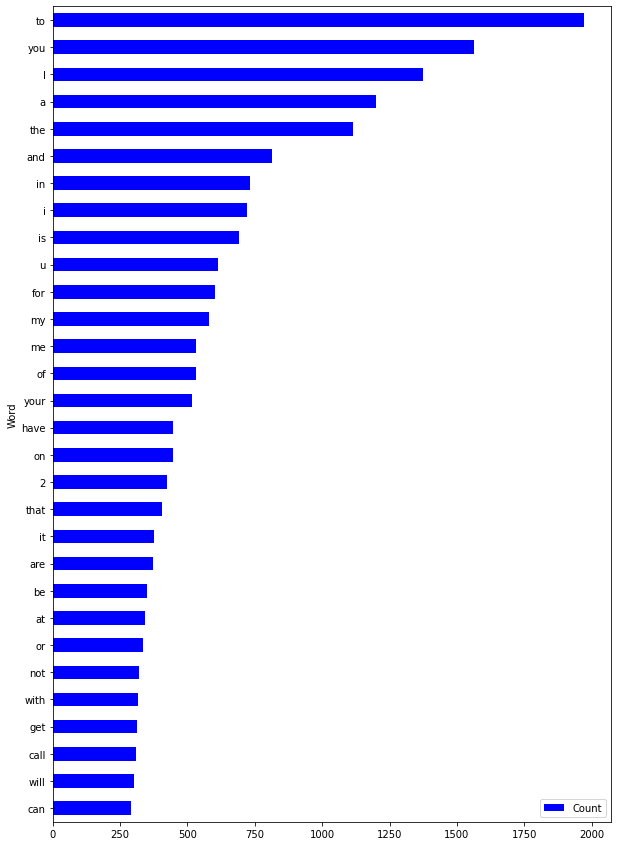

In [8]:
import collections
def word_count_plot(data):
     word_counter = collections.Counter([word for sentence in data for word in sentence.split()])
     most_count = word_counter.most_common(30)
     most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
     most_count.plot.barh(x = "Word", y = "Count", color="blue", figsize=(10, 15))
word_count_plot(df["Text"])

## Plotting ham and spam data % in pie chart

In [9]:
df["Label"].value_counts()

ham     4516
spam     653
Name: Label, dtype: int64

ham     4516
spam     653
Name: Label, dtype: int64


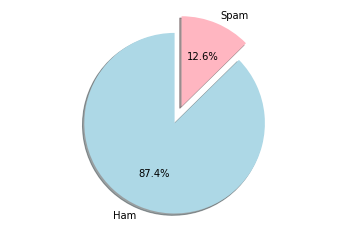

In [10]:
count_Class = pd.value_counts(df.Label, sort = True)
print(count_Class)
labels = 'Ham', 'Spam'
sizes = [count_Class[0], count_Class[1]]
colors = ['lightblue', 'lightpink']
explode = (0.1, 0.1)
plt.pie(sizes, explode = explode, labels = labels, colors = colors,autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["Label"])

In [12]:
df["Label"] = [1 if each == "spam" else 0 for each in df["Label"]]

print('df: ')
print(df.head(), '\n')

df: 
   Label                                               Text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro... 



In [13]:
X = df.iloc[:, 1].values
X = X.reshape(-1, 1)
print('Type of X:', type(X))
print('shape of X: ', X.shape)
#print(X)

Y = df.iloc[:, 0].values
y = Y.reshape(-1, 1)
print('Type of Y; ', type(Y))
print('shape of Y: ', y.shape)
#print(y)
X = X.tolist()
y = y.tolist()
print('Length of X: ', len(X), '\n')

Type of X: <class 'numpy.ndarray'>
shape of X:  (5169, 1)
Type of Y;  <class 'numpy.ndarray'>
shape of Y:  (5169, 1)
Length of X:  5169 



In [26]:
Training_Sentences = X[800:]
Training_Labels = y[800:]
print('Length of training samples ', len(Training_Sentences), '\n')

Testing_Sentences = X[0:800]
Testing_Lables = y[0:800]
print('Length of testing samples', len(Testing_Sentences), '\n')

Length of training samples  4369 

Length of testing samples 800 



In [27]:
tokenizer = Tokenizer(num_words=10000, oov_token='')
tokenizer.fit_on_texts(Training_Sentences)
word_index = tokenizer.word_index
Training_Sequences = tokenizer.texts_to_sequences(Training_Sentences)
Training_pad = pad_sequences(Training_Sequences, maxlen=32, padding='post', truncating='post')
Testing_Sequences = tokenizer.texts_to_sequences(Testing_Sentences)
Testing_pad = pad_sequences(Testing_Sequences, maxlen=32, padding='post', truncating='post')

In [28]:
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, 16, input_length=32))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(24, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 128)          41472     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 24)                98328     
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 299,825
Trainable params: 299,825
Non-trainable params: 0
________________________________________________

In [29]:
Training_Sequences_padded = np.asarray(Training_pad)
Testing_Sequences_padded = np.asarray(Testing_pad)
Training_Labels = np.asarray(Training_Labels)
Testing_Lables = np.asarray(Testing_Lables)

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(Training_Sequences_padded, Training_Labels, validation_data=(Testing_Sequences_padded, Testing_Lables), epochs=10)

Epoch 1/10
137/137 [==============================] - 11s 47ms/step - loss: 0.3920 - accuracy: 0.8723 - val_loss: 0.4284 - val_accuracy: 0.8487
Epoch 2/10
137/137 [==============================] - 5s 38ms/step - loss: 0.3700 - accuracy: 0.8782 - val_loss: 0.4249 - val_accuracy: 0.8487
Epoch 3/10
137/137 [==============================] - 7s 48ms/step - loss: 0.2026 - accuracy: 0.9348 - val_loss: 0.4290 - val_accuracy: 0.8487
Epoch 4/10
137/137 [==============================] - 5s 37ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 0.8491 - val_accuracy: 0.1525
Epoch 5/10
137/137 [==============================] - 5s 38ms/step - loss: 3.0864e-04 - accuracy: 1.0000 - val_loss: 1.1038 - val_accuracy: 0.1525
Epoch 6/10
137/137 [==============================] - 5s 38ms/step - loss: 9.3235e-05 - accuracy: 1.0000 - val_loss: 0.8643 - val_accuracy: 0.1525
Epoch 7/10
137/137 [==============================] - 5s 38ms/step - loss: 4.5961e-05 - accuracy: 1.0000 - val_loss: 0.6571 - val_acc

In [32]:
text = 'congratulations lottery winner'
print(text)
Test = tokenizer.texts_to_sequences([text])[0]
Test_padded = pad_sequences([Test], maxlen=32, padding='post', truncating='post')
Test_padded = np.asarray(Test_padded)
print(Test_padded.shape)

congratulations lottery winner
(1, 32)


In [33]:
ypred = model.predict(Test_padded)
ypred

1/1 [==============================] - 1s 972ms/step


array([[0.99995387]], dtype=float32)